# Crash Predictive ML Model

We will create a tree based model to predict the daily number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
- violations
- red light cam presence
- congestion
- covid cases


This time we will look at whole city, and use only global variables for city.

In [2]:

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import plotly_express as px
import plotly

import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from modules.myfuncs import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from boruta import BorutaPy

import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

from datetime import datetime


In [3]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db



We will try to get data that is daily for all of the above info.  

In [4]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('all_days',), ('daily_covid',), ('all_hours',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	injuries_total
	injuri

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [5]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection


In [6]:
# This one groups by day for the whole city

big_df = pd.read_sql_query('''
WITH ah AS(SELECT year,
                month,
                day,
                hour,
                datetime,
                intersection
                
        FROM all_hours
        ),   


    ich AS(SELECT intersection,
                protected_turn,
                total_lanes,
                medians,
                exit,
                split,
                way,
                underpass,
                no_left,
                angled,
                triangle,
                one_way,
                turn_lanes,
                lat,
                long,
                rlc,
                daily_traffic,
                speed
            FROM intersection_chars
        ),


    v AS(SELECT year,
                month,
                day,
                intersection,
                violations
            FROM daily_violations
            GROUP by year, month, day, intersection
        ),

    wx AS(SELECT SUM(snow_1h + rain_1h) AS precip_1h,
                SUM(snow_1h) as snow_1h,
                SUM(rain_1h) as rain_1h,
                MAX(temp) as temp_1h,
                year,
                month,
                day,
                hour
            FROM hourly_weather
            GROUP BY year, month, day, hour
        ),
    
    wxd AS(SELECT SUM(snow_1h + rain_1h) AS precip_daily,
                SUM(snow_1h) as snow_daily,
                SUM(rain_1h) as rain_daily,
                MAX(temp) as temp_daily,
                year,
                month,
                day
            FROM hourly_weather
            GROUP BY year, month, day
        ),

    cr AS(SELECT SUM(injuries_total) AS injuries,
                year,
                month,
                day,
                hour,
                intersection,
                COUNT(DISTINCT crash_record_id) AS n_crash,
                SUM(COALESCE(injuries_total,0)) AS injuries,
                SUM(injuries_fatal) AS injuries_fatal,
                SUM(injuries_incapacitating) AS injuries_incapacitating
         FROM signal_crashes
         GROUP BY year, month, day, hour, intersection
        ),
        
    cov AS(SELECT strftime('%m',lab_report_date) AS month,
            strftime('%Y',lab_report_date) AS year,
            strftime('%d',lab_report_date) AS day,
            lab_report_date,
            cases_total as covid_cases
        FROM daily_covid as dc
        GROUP BY year, month, day
        ),
        
    cg AS(SELECT year,
                month,
                day,
                hour,
                region_id,
                (100-AVG(quantile_speed))/100 as congestion

        FROM hourly_congestion
        GROUP BY year, month, day, hour, region_id),
    
    ic AS(SELECT intersection,
                region_id
            FROM intersection_cams
            )
        

    SELECT 
        ah.year,
        ah.month,
        ah.day,
        ah.hour,
        ah.intersection,
        ah.datetime,
        v.violations,

        wx.snow_1h,
        wx.rain_1h,
        wx.precip_1h,
        wx.temp_1h,
        
        wxd.snow_daily,
        wxd.rain_daily,
        wxd.precip_daily,
        wxd.temp_daily,

        cr.n_crash,
        cr.injuries,
        cr.injuries_fatal,
        cr.injuries_incapacitating,
        
        ich.protected_turn,
        ich.total_lanes,
        ich.medians,
        ich.exit,
        ich.split,
        ich.way,
        ich.underpass,
        ich.no_left,
        ich.angled,
        ich.triangle,
        ich.one_way,
        ich.turn_lanes,
        ich.lat,
        ich.long,
        ich.rlc,
        ich.daily_traffic,
        ich.speed as speed_limit,
        
        cov.covid_cases,
        
        ic.region_id,
        
        cg.congestion

    FROM ah
    LEFT JOIN v
        ON v.year = ah.year
        AND v.month = ah.month
        AND v.day = ah.day
        AND v.intersection = ah.intersection
    LEFT JOIN cr
        ON cr.year = ah.year
        AND cr.month = ah.month
        AND cr.day = ah.day
        AND cr.hour = ah.hour
        AND cr.intersection = ah.intersection
    
    LEFT JOIN wx
        ON wx.year = ah.year
        AND wx.month = ah.month
        AND wx.day = ah.day
        AND wx.hour = ah.hour
    LEFT JOIN wxd
        ON wxd.year = ah.year
        AND wxd.month = ah.month
        AND wxd.day = ah.day
    LEFT JOIN cov
        ON cov.year = ah.year
        AND cov.month = ah.month
        AND cov.day = ah.day
    LEFT JOIN ich
        ON ich.intersection = ah.intersection
    LEFT JOIN ic
        ON ic.intersection = ah.intersection
    LEFT JOIN cg
        ON cg.year = ah.year
        AND cg.month = ah.month
        AND cg.day = ah.day
        AND cg.hour = ah.hour
        AND cg.region_id = ic.region_id
    WHERE ah.year > 2016

    GROUP BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
    ORDER BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
                                    ''', conn)

# don't forget to reset the WHERE statement
'''

        


   
'''

'\n\n        \n\n\n   \n'

In [7]:
big_df.head(50)
big_df.shape
print(365*4*24*150)

5256000


In [8]:
big_df.intersection.value_counts()

LAWRENCE AND WESTERN            36168
ELSTON AND ADDISON              36168
IRVING PARK AND NARRAGANSETT    36168
79TH AND HALSTED                36168
PERSHING AND WESTERN            36168
                                ...  
MILWAUKEE AND DEVON             36168
BROADWAY/SHERIDAN AND DEVON     36168
55TH AND WESTERN                36168
WESTERN AND 79TH                36168
DAMEN AND DIVERSEY              36168
Name: intersection, Length: 157, dtype: int64

In [9]:
all_df = big_df.copy()

In [10]:
print(all_df.shape)
n = len(all_df.intersection.unique())
print((365.25*4) * 24 * n)
print(120 * 24 * n)  #reduced dataset

(5678376, 39)
5505048.0
452160


In [11]:
all_df.isna().sum()


year                             0
month                            0
day                              0
hour                             0
intersection                     0
datetime                   5642208
violations                  513120
snow_1h                          0
rain_1h                          0
precip_1h                        0
temp_1h                          0
snow_daily                       0
rain_daily                       0
precip_daily                     0
temp_daily                       0
n_crash                    5671185
injuries                   5671186
injuries_fatal             5671186
injuries_incapacitating    5671186
protected_turn                   0
total_lanes                      0
medians                          0
exit                             0
split                            0
way                              0
underpass                        0
no_left                          0
angled                           0
triangle            

In [12]:
all_df['violations'] = all_df['violations'].fillna(0).astype(int)
all_df['covid_cases'] = all_df['covid_cases'].fillna(0).astype(int)
all_df['n_crash'] = all_df['n_crash'].fillna(0).astype(int)
all_df['injuries'] = all_df['injuries'].fillna(0).astype(int)
all_df['congestion'] = all_df.congestion.fillna(0.01)


In [13]:
pd.options.display.max_rows = 153
pd.options.display.max_columns = 200

all_df.describe()

,year,month,day,hour,violations,snow_1h,rain_1h,precip_1h,temp_1h,snow_daily,rain_daily,precip_daily,temp_daily,n_crash,injuries,injuries_fatal,injuries_incapacitating,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed_limit,covid_cases,congestion
count,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,7190.000000,7190.000000,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06,5678376.0,5.678376e+06,5.678376e+06,5.678376e+06,5.678376e+06
mean,2.018577e+03,6.364300e+00,1.565826e+01,1.150000e+01,4.944974e+00,1.910999e-02,1.834508e-01,2.025608e-01,2.851038e+02,4.586397e-01,4.402820e+00,4.861460e+00,2.896934e+02,1.272723e-03,4.853500e-04,0.002225,0.039221,2.191083e+00,6.611465e+00,4.267516e-01,1.146497e-01,5.095541e-02,4.108280e+00,1.337580e-01,2.356688e-01,1.401274e-01,1.656051e-01,2.101911e-01,3.292994e+00,4.188219e+01,-8.769859e+01,1.0,5.127707e+04,3.566879e+01,1.596151e+02,4.677074e-01
std,1.182078e+00,3.512326e+00,8.803428e+00,6.922187e+00,6.678349e+00,2.150087e-01,1.349217e+00,1.372865e+00,1.127174e+01,2.214611e+00,1.176923e+01,1.207105e+01,1.168295e+01,3.582992e-02,3.323640e-02,0.057736,0.232598,1.604666e+00,1.887437e+00,7.754500e-01,3.185987e-01,2.199067e-01,4.595708e-01,4.385202e-01,6.196376e-01,3.471192e-01,3.717258e-01,5.646920e-01,1.273248e+00,8.403235e-02,5.118950e-02,0.0,1.440747e+04,3.528571e+00,4.217809e+02,2.997615e-01
min,2.017000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.453700e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.553700e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.167777e+01,-8.781223e+01,1.0,2.160000e+04,3.000000e+01,0.000000e+00,0.000000e+00
25%,2.018000e+03,3.000000e+00,8.000000e+00,5.750000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.759500e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.801500e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,4.180844e+01,-8.773630e+01,1.0,4.220000e+04,3.500000e+01,0.000000e+00,2.009566e-01
50%,2.019000e+03,6.000000e+00,1.600000e+01,1.150000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.841500e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.892600e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.190362e+01,-8.769939e+01,1.0,4.920000e+04,3.500000e+01,0.000000e+00,4.620509e-01
75%,2.020000e+03,9.000000e+00,2.300000e+01,1.725000e+01,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.951500e+02,0.000000e+00,2.400000e+00,3.230000e+00,3.003500e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,4.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.194612e+01,-8.766270e+01,1.0,5.830000e+04,3.500000e+01,0.000000e+00,7.232385e-01
max,2.021000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.510000e+02,1.680000e+01,7.710000e+01,7.710000e+01,3.103700e+02,2.757000e+01,1.229000e+02,1.229000e+02,3.103700e+02,2.000000e+00,2.100000e+01,2.000000,5.000000,4.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,6.000000e+00,4.201223e+01,-8.757537e+01,1.0,1.055000e+05,6.500000e+01,3.356000e+03,9.999767e-01


In [14]:
all_df.isna().sum()

year                             0
month                            0
day                              0
hour                             0
intersection                     0
datetime                   5642208
violations                       0
snow_1h                          0
rain_1h                          0
precip_1h                        0
temp_1h                          0
snow_daily                       0
rain_daily                       0
precip_daily                     0
temp_daily                       0
n_crash                          0
injuries                         0
injuries_fatal             5671186
injuries_incapacitating    5671186
protected_turn                   0
total_lanes                      0
medians                          0
exit                             0
split                            0
way                              0
underpass                        0
no_left                          0
angled                           0
triangle            

In [15]:
# high cost .apply method 
all_df['datetime'] = all_df.apply(lambda x: datetime(x.year, x.month, x.day, x.hour), axis=1)

In [ ]:
import datetime

all_df = all_df[(all_df['datetime'] >= datetime.date(2017, 9, 1, 0)) &
                (all_df['datetime'] < datetime.date(2021, 1, 1, 0))]

In [16]:

all_df['weekday'] = all_df['datetime'].apply(lambda x: x.strftime("%A"))
all_df['month'] = all_df['datetime'].apply(lambda x: x.strftime("%b"))
all_df['covid_cases'] = all_df.covid_cases.astype(int)

all_df[['n_crash', 'violations', 'injuries']] = all_df[['n_crash', 'violations', 'injuries']].fillna(0)

## Define X and y

In [17]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5678376 entries, 0 to 5678375
Data columns (total 40 columns):
year                       int64
month                      object
day                        int64
hour                       int64
intersection               object
datetime                   datetime64[ns]
violations                 int64
snow_1h                    float64
rain_1h                    float64
precip_1h                  float64
temp_1h                    float64
snow_daily                 float64
rain_daily                 float64
precip_daily               float64
temp_daily                 float64
n_crash                    int64
injuries                   int64
injuries_fatal             float64
injuries_incapacitating    float64
protected_turn             int64
total_lanes                int64
medians                    int64
exit                       int64
split                      int64
way                        int64
underpass                  int6

In [18]:
y = all_df['n_crash'].fillna(0).astype(bool)

drop_cols = ['injuries', 'injuries_fatal', 'injuries_incapacitating', 'n_crash', 'datetime', 'day', 'lat', 'long']

X = all_df.drop(columns=drop_cols) 

In [19]:

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5678376 entries, 0 to 5678375
Data columns (total 32 columns):
year              int64
month             object
hour              int64
intersection      object
violations        int64
snow_1h           float64
rain_1h           float64
precip_1h         float64
temp_1h           float64
snow_daily        float64
rain_daily        float64
precip_daily      float64
temp_daily        float64
protected_turn    int64
total_lanes       int64
medians           int64
exit              int64
split             int64
way               int64
underpass         int64
no_left           int64
angled            int64
triangle          int64
one_way           int64
turn_lanes        int64
rlc               int64
daily_traffic     int64
speed_limit       int64
covid_cases       int64
region_id         object
congestion        float64
weekday           object
dtypes: float64(9), int64(19), object(4)
memory usage: 1.4+ GB


## Create dummy variables

In [20]:
X = pd.get_dummies(X)
print(len(X.columns))
#X = X.drop(columns=boruta_drop) 



231


In [21]:
y.sum()/y.count()  # very rare event

0.0012663832053389913

### Train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [23]:
print(y.sum())

7191


In [24]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
forest.score(X_test, y_test)

0.9987038556771474

In [32]:
pred = forest.predict(X_test)

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test.astype(bool), pred).ravel()
print(tn, fp, fn, tp)

1134203 54 1418 1


### Train test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


AUC: 0.5939877028632216


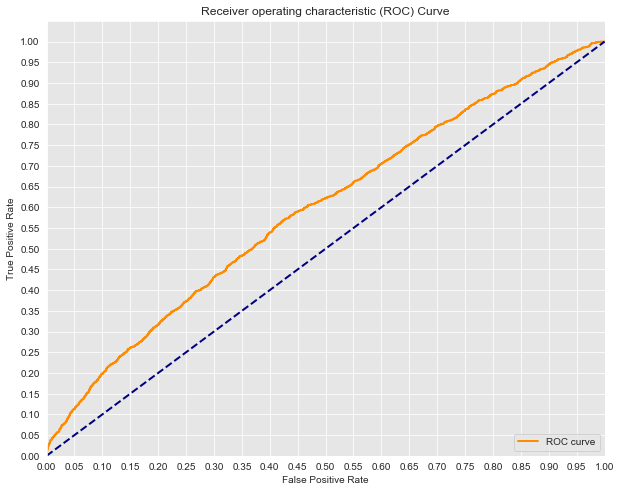

In [35]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#SMOTE
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

# Note, if you get an Attribute Error: 'SMOTE' object has no attribute
# '_validate_data', then downgrade your version of imblearn to 0.6.2
# or upgrade your version of sklearn to 0.23

False    4536904
True        5796
Name: n_crash, dtype: int64


In [ ]:
# SMOTE OVERSAMPLING

# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 1,.5, 2, 4, 10, 20, 50]
names = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 1,.5, 2, 4, 10, 20, 50]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Fit a model
logreg = LogisticRegression(fit_intercept=False, C=0.1, solver='liblinear')

# Fit SMOTE to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

model_log = logreg.fit(X_train_resampled, y_train_resampled)
print(model_log) # Preview model params

# Predict
y_hat_test = logreg.predict(X_test)

y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
print('-------------------------------------------------------')

lw = 2
plt.plot(fpr, tpr, color=colors[n], lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
decisions = logreg.predict(X_test)
cm = confusion_matrix(decisions, y_test.astype(int))
#y2_test.unique()
cm

In [ ]:
# Machine learning improvement
n = cm[0].sum() + cm[1].sum()  # all test 

p0 = y_test.sum() / len(y_test)  # what is the guess rate I would use if I didn't know anything else
p1 = 1 - p0

guessing = p0**2 + p1**2

print('Probability with guessing: {:.3f}'.format(guessing))

ml = (cm[1][1] + cm[0][0]) / n
print('Probability with machine learning: {:.3f}'.format(ml))

increase = (ml - guessing) / guessing
print('\nPercent increase: {:.2%}'.format(increase))

In [ ]:
probs = logreg.predict_proba(X)
probs.shape[:5]
probs[:5]

In [ ]:
# let's look at a single intersection
X_int = X[X['intersection_75TH AND STATE']==1]

y_int = all_df[all_df['intersection']=='75TH AND STATE']['n_crash'].astype(bool).astype(int)
y_prob = logreg.predict_proba(X_int)



In [ ]:
import plotly.express as px


fig = px.line(all_df2, x='violation_date', y='prob', width=1000, height=400,) # hover_data=[]
fig.add_scatter(x=all_df2.violation_date, y=all_df2.n_crash, mode='markers', name='model predict')

fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="left",
                            x=0.01),
                  yaxis_title="Violations",
                 )

fig.update_layout(margin=dict(
                                        l=0, #left margin
                                        r=0, #right margin
                                        b=0, #bottom margin
                                        t=0  #top margin
                                        )
                    )
                    


fig.show()


In [ ]:
X.head()